/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 383.2539 - mae: 42.9270 - val_loss: 264.6793 - val_mae: 31.2259 - learning_rate: 0.0010
Epoch 2/200
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 93.1086 - mae: 13.4191 - val_loss: 222.6199 - val_mae: 26.9602 - learning_rate: 0.0010
Epoch 3/200
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 85.8268 - mae: 12.6570 - val_loss: 73.4889 - val_mae: 11.2808 - learning_rate: 0.0010
Epoch 4/200
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 76.3588 - mae: 11.5903 - val_loss: 62.4645 - val_mae: 10.0898 - learning_rate: 0.0010
Epoch 5/200
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 72.7586 - mae: 11.2048 - val_loss: 81.3398 - val_mae: 12.0939 - learning_rate: 0.0010
Epoch 6/200
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 74.1385 - mae: 11.3624 - val_loss: 89.8903 - val_mae: 12.9287 - learning_rate: 0.0010
Epoch 7/200
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 65.2413 - mae: 10.3456 - val_loss: 63.5892 - v

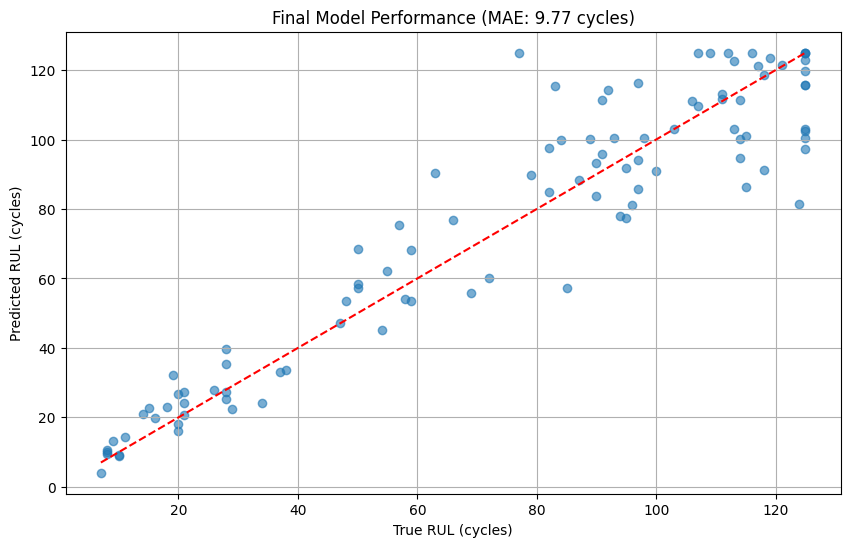

In [58]:
# STEP 1: IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber

# STEP 2: LOAD TRAIN DATA
train = pd.read_csv('/kaggle/input/predictive-maintenance/train_FD001.txt', sep=' ', header=None)
train.dropna(axis=1, inplace=True)
train.columns = ['id', 'cycle', 'op1', 'op2', 'op3'] + [f'sensor_{i}' for i in range(1, 22)]

# STEP 3: FEATURE SELECTION
sensor_cols = [f'sensor_{i}' for i in range(1, 22)]
low_var = train[sensor_cols].std() < 0.01
sensor_cols = [col for col in sensor_cols if not low_var[col]]

# STEP 4: RUL TARGET CREATION
max_rul = 125
train['RUL'] = train.groupby('id')['cycle'].transform('max') - train['cycle']
train['RUL'] = train['RUL'].clip(upper=max_rul)

# STEP 5: SCALING
scaler = MinMaxScaler()
train[sensor_cols] = scaler.fit_transform(train[sensor_cols])

# STEP 6: SLIDING WINDOW SEQUENCES
window_size = 60
X, y, groups = [], [], []
for eid in train['id'].unique():
    temp = train[train['id'] == eid]
    for i in range(window_size, len(temp)):
        X.append(temp.iloc[i-window_size:i][sensor_cols].values)
        y.append(temp.iloc[i]['RUL'])
        groups.append(eid)
X, y, groups = np.array(X), np.array(y), np.array(groups)

# STEP 7: GROUPKFOLD SPLIT
gkf = GroupKFold(n_splits=5)
train_idx, val_idx = next(gkf.split(X, y, groups))
X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]

# STEP 8: MODEL ARCHITECTURE
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(window_size, len(sensor_cols))),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='relu')
])
model.compile(optimizer='adam', loss=Huber(delta=10.0), metrics=['mae'])

# STEP 9: TRAIN MODEL
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=7, factor=0.5, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# STEP 10: LOAD TEST DATA
test = pd.read_csv('/kaggle/input/predictive-maintenance/test_FD001.txt', sep=' ', header=None)
test.dropna(axis=1, inplace=True)
test.columns = ['id', 'cycle', 'op1', 'op2', 'op3'] + [f'sensor_{i}' for i in range(1, 22)]
test[sensor_cols] = scaler.transform(test[sensor_cols])

#  STEP 11: PREPARE TEST WINDOWS
X_test = []
for eid in test['id'].unique():
    temp = test[test['id'] == eid]
    seq = temp[sensor_cols].values
    if len(seq) < window_size:
        # Pad with zeros
        pad = np.zeros((window_size - len(seq), len(sensor_cols)))
        seq = np.vstack((pad, seq))
    else:
        seq = seq[-window_size:]
    X_test.append(seq)

X_test = np.array(X_test)

#  STEP 12: LOAD TRUE RUL FROM FILE
rul_true = pd.read_csv('/kaggle/input/pm-lstm/RUL_FD001.txt', sep=' ', header=None)
rul_true = rul_true.dropna(axis=1)
rul_true.columns = ['RUL']
y_true = rul_true['RUL'].clip(upper=max_rul).values

#  STEP 13: PREDICT & EVALUATE
y_pred = model.predict(X_test).flatten()
y_pred = np.clip(y_pred, 0, max_rul)
mae = mean_absolute_error(y_true, y_pred)
print(f"\n Final MAE: {mae:.2f} cycles")

#  STEP 14: VISUALIZE
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.xlabel('True RUL (cycles)')
plt.ylabel('Predicted RUL (cycles)')
plt.title(f'Final Model Performance (MAE: {mae:.2f} cycles)')
plt.grid(True)
plt.show()